In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import TensorDataset, DataLoader

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor

import sys; sys.path.insert(0, '..')
from models.VAR.metrics import root_mean_squared_error, mean_absolute_percentage_error

sns.set(font_scale=1.5)
%matplotlib inline

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using cpu


In [9]:
DATA_PATH = "../data/nasdaq100_padding.csv"
prediction_horizons = [3, 6, 12, 24]
train_prediction = [3, 6, 12, 21, 30]
batch_size = 32
D_size=5

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
class DiffLogScaler:
    def fit_transform(
        self, 
        X: np.ndarray
    ):
        """
        X : [num_samples, dimension]
        строит новый ряд z_{i} = ln(y_{i} / y_{i-1})
        """
        self.X_0 = np.log(X)[0, ]
        return np.diff(np.log(X), axis = 0)


    def inverse_transform(
        self,
        X: np.ndarray
    ):
        return np.exp(
            np.concatenate(
                ([self.X_0], X)
            ).cumsum(axis=0)
        )        

In [5]:
class Preprocessor:
    def __init__(
        self,
        dataset:np.ndarray,
        max_pred_horizon:int=28,
        max_train_horizon:int=30,
        D_size:int=5,
        device=None,
    ):
        """
        dataset = [num_samples, dimentions]
        """
        self.dataset = dataset[:, :D_size]
        self.raw_dataset = dataset[:, :D_size]
        self.max_pred_horizon=max_pred_horizon
        self.max_train_horizon=max_train_horizon
        self.D_size = D_size
        self.device = device
        self.scaler = None
        self.train_size = None
        self.val_size = None
        self.test_size = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.batch_size = None

    def scale(
        self,
        scaler=DiffLogScaler, 
    ):
        """
        Scaler needs to be smth like sklearn transformer
        """
        self.scaler = scaler()
        self.dataset = self.scaler.fit_transform(self.dataset)

    def get_scaled_back(
        self,
        dataset:np.ndarray,
    ) -> np.ndarray:
        if self.scaler is not None:
            return self.scaler.inverse_transform(dataset)
        return dataset

    def _plot_row(
        self,
        row:int,
    ):
        plt.title('{} row'.format(str(row)))
        if self.scaler is None:
            plt.plot(self.dataset[:, row])
        else:
            plt.plot(self.scaler.inverse_transform(self.dataset)[:, row])
        if self.train_size is not None:
            plt.axvline(x=self.train_size)
        if self.val_size is not None:
            plt.axvline(x=self.train_size+self.val_size)
        plt.show()

    def plot_dataset(
        self,
        row:int=None,
    ):
        if row is None:
            for i in range(self.dataset.shape[1]):
                self._plot_row(row=i)
        else:
            self._plot_row(row=row)

    def get_data(
        self,
        name:str,
        torch_tensor=True,
        to_device=True,
    ) -> torch.Tensor:
        if name not in [
            'X_train', 'X_val', 'X_test',
            'y_train', 'y_val', 'y_test',
        ]:
            raise "Private field cannot be accessed"
        else:
            if torch_tensor:
                return torch.Tensor(getattr(self, name)).to(self.device)
            return getattr(self, name)

    def get_dataloader(
        self,
        name:str,
        batch_size=128,
    ) -> torch.utils.data.DataLoader:
        self.batch_size = batch_size
        if name not in [
            'train', 'val', 'test',
        ]:
            raise "Incorrect type"
        X = torch.Tensor(getattr(self, 'X_'+name)).to(self.device)
        y = torch.Tensor(getattr(self, 'y_'+name)).to(self.device)
        if X is None:
            raise "Doesn't have the field of this type"
        if name == 'train':
            return DataLoader(
                      TensorDataset(X, y),
                      shuffle=True,
                      batch_size=batch_size,
                    )
        return DataLoader(
                  TensorDataset(X, y),
                  shuffle=False,
                  batch_size=batch_size,
                )

    def _make_X_part(
        self,
        begin:int,
        end:int,
        use_tqdm:bool=True,
    ) -> np.ndarray:
        """
        X = [num_samples, max_train_horizon, D_size]
        """
        X = self.dataset[begin:begin+self.max_train_horizon,
                         :][np.newaxis, :, :]
        if use_tqdm:
            for i in tqdm.tqdm(range(begin+1, end)):
                new_elem = self.dataset[i:i+self.max_train_horizon,
                                        :][np.newaxis, :, :]
                X = np.concatenate((X, new_elem))
        else:
            for i in range(begin+1, end):
                new_elem = self.dataset[i:i+self.max_train_horizon,
                                        :][np.newaxis, :, :]
                X = np.concatenate((X, new_elem))
        return X

    def _make_y_part(
        self,
        begin:int,
        end:int,
        use_tqdm:bool=True,
    ) -> np.ndarray:
        """
        y = [num_samples, max_pred_horizon, D_size]
        """
        y = self.dataset[begin+self.max_train_horizon:begin+
                         self.max_train_horizon+self.max_pred_horizon,
                         :][np.newaxis, :, :]
        if use_tqdm:
            for i in tqdm.tqdm(range(begin+1+self.max_train_horizon, 
                                     end+self.max_train_horizon)):
                new_elem = self.dataset[i:i+self.max_pred_horizon, 
                                        :][np.newaxis, :, :]
                y = np.concatenate((y, new_elem))
        else:
            for i in range(begin+1+self.max_train_horizon, 
                           end+self.max_train_horizon):
                new_elem = self.dataset[i:i+self.max_pred_horizon,
                                        :][np.newaxis, :, :]
                y = np.concatenate((y, new_elem))
        return y

    def train_test_split(
        self,
        train_size:int,
        use_tqdm:bool=True,
    ):
        self.val_size = None
        self.X_val, self.y_val = None, None
        self.train_size = train_size
        self.test_size = self.dataset.shape[0] - self.max_train_horizon -\
            self.max_pred_horizon - self.train_size
        self.X_train = self._make_X_part(
            begin=0,
            end=train_size,
            use_tqdm=use_tqdm
        ) 
        self.y_train = self._make_y_part(
            begin=0,
            end=train_size,
            use_tqdm=use_tqdm
        )
        self.X_test = self._make_X_part(
            begin=train_size,
            end=self.dataset.shape[0]-self.max_train_horizon
            -self.max_pred_horizon,
            use_tqdm=use_tqdm
        )
        self.y_test = self._make_y_part(
            begin=train_size,
            end=self.dataset.shape[0]-self.max_train_horizon
            -self.max_pred_horizon,
            use_tqdm=use_tqdm
        )  
    
    def train_val_test_split(
        self,
        train_size:int,
        val_size:int,
        use_tqdm:bool=True,
    ):
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = self.dataset.shape[0] - self.max_train_horizon -\
            self.max_pred_horizon - train_size - val_size
        self.X_train = self._make_X_part(
            begin=0,
            end=train_size,
            use_tqdm=use_tqdm
        ) 
        self.y_train = self._make_y_part(
            begin=0,
            end=train_size,
            use_tqdm=use_tqdm
        )
        self.X_val = self._make_X_part(
            begin=train_size,
            end=train_size+val_size,
            use_tqdm=use_tqdm
        ) 
        self.y_val = self._make_y_part(
            begin=train_size,
            end=train_size+val_size,
            use_tqdm=use_tqdm
        )
        self.X_test = self._make_X_part(
            begin=train_size+val_size,
            end=self.dataset.shape[0]-self.max_train_horizon
            -self.max_pred_horizon,
            use_tqdm=use_tqdm
        )
        self.y_test = self._make_y_part(
            begin=train_size+val_size,
            end=self.dataset.shape[0]-self.max_train_horizon
            -self.max_pred_horizon,
            use_tqdm=use_tqdm
        )  
        

In [10]:
preproc = Preprocessor(
    dataset=df.iloc[:40000, :].to_numpy(),
    device=device,
)
preproc.scale()
preproc.train_val_test_split(
    train_size=30000,
    val_size=5000,
    use_tqdm=True,
)

100%|██████████| 4940/4940 [00:02<00:00, 2250.32it/s] 


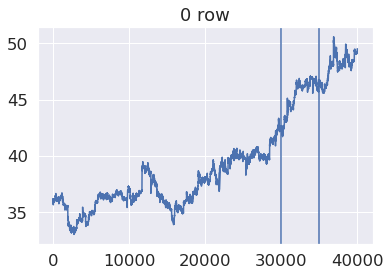

In [11]:
preproc.plot_dataset(0)

In [12]:
class CatBoost_model:
    def __init__(
        self,
        use_gpu=True,
        device=None,
        loss_function='MAE',
        multi_target=False,
        params=None
    ):
        if params is not None:
            if use_gpu:
                    self.cbr = CatBoostRegressor(
                    loss_function=loss_function,
                    task_type="GPU",
                    devices='cuda:0',
                    verbose=100,
                    **params,
                )
            else:
                self.cbr = CatBoostRegressor(
                    loss_function=loss_function,
                    verbose=100,
                    **params,
                )
        else:
            if use_gpu:
              self.cbr = CatBoostRegressor(
                  loss_function=loss_function,
                  task_type="GPU",
                  devices='cuda:0',
                  verbose=100,
              )
            else:
                self.cbr = CatBoostRegressor(
                    loss_function=loss_function,
                    verbose=100,
                )
        if multi_target:
            self.cbr = MultiOutputRegressor(self.cbr)
        self.train_horizon_union = None
        self.row_ind_union = None
        self.train_horizon_multi = None
        self.pred_horizon_multi = None
    
    def train_union(
        self,
        X_train,
        y_train,
        train_horizon:int,
        row_ind:int=0,
    ):
        self.train_horizon_union = train_horizon
        self.row_ind_union = row_ind
        self.cbr.fit(
            X_train[:, -self.train_horizon_union:, :].reshape(len(X_train), -1),
            y_train[:, 0, self.row_ind_union],
        )

    def train_multi(
        self,
        X_train,
        y_train,
        train_horizon:int,
        pred_horizon:int,
    ):
        self.train_horizon_multi = train_horizon
        self.pred_horizon_multi = pred_horizon
        self.cbr.fit(
            X_train[:, -self.train_horizon_multi:, :].reshape(len(X_train), -1),
            y_train[:, :self.pred_horizon_multi, :].reshape(len(y_train), -1),
        )

    def pred_union(
        self,
        X_data,
        y_data,
        horizon_pred_out:int,
    ):
        assert horizon_pred_out >= 1
        output = [
            self.cbr.predict(
                X_data[:, -self.train_horizon_union:, :].reshape(len(X_data), -1),
            )
        ]
        print(output)
        print(y_data[:, :horizon_pred_out, self.row_ind_union])
        additional_X = np.copy(y_data)
        for i in range(1, horizon_pred_out):
            additional_X[:, i-1, self.row_ind_union] = output[-1]
            if X_data.shape[1] > i:
                output.append(
                    self.cbr.predict(
                        np.concatenate(
                            (
                                X_data[:, -self.train_horizon_union+i:, :],
                                additional_X[:, :i, :],
                            ),
                            axis=1,
                        ).reshape(len(X_data), -1)
                    )
                )
            else:
                output.append(
                    self.cbr.predict(
                        additional_X[:, :i, :],
                    ).reshape(len(X_data), -1)
                )
        #FIXME
        print(output)
        print('==================')
        print(np.array(output).reshape(5000, -1))
        print(np.array(output).reshape(5000, -1).shape)
        # raise
        output = list(map(lambda x: x[::-1], np.array(output).reshape(5000, -1)))
        return (
            np.array(output).reshape(-1, horizon_pred_out),
            y_data[:, :horizon_pred_out, self.row_ind_union]
        )

    def pred_multi(
        self,
        X_pred,
    ):
        #FIXME
        return self.pred_union(
            X_pred[:, -self.train_horizon_multi:, :].reshape(len(X_train), -1),
        )


In [15]:
cbr = CatBoost_model(
    use_gpu=False,
    loss_function='RMSE',
    multi_target=False,
    params={'iterations':2000,},
)

In [16]:
cbr.train_union(
    X_train=preproc.get_data(
        name='X_train',
        torch_tensor=False,
        to_device=False
    ),
    y_train=preproc.get_data(
        name='y_train',
        torch_tensor=False,
        to_device=False
    ),
    train_horizon=30,
    row_ind=0,
)

Learning rate set to 0.042223
0:	learn: 0.0010345	total: 199ms	remaining: 6m 37s
100:	learn: 0.0009965	total: 3.58s	remaining: 1m 7s
200:	learn: 0.0009665	total: 7.11s	remaining: 1m 3s
300:	learn: 0.0009414	total: 10.6s	remaining: 59.8s
400:	learn: 0.0009162	total: 14.3s	remaining: 57.1s
500:	learn: 0.0008936	total: 18.8s	remaining: 56.2s
600:	learn: 0.0008715	total: 24.4s	remaining: 56.9s
700:	learn: 0.0008499	total: 28.5s	remaining: 52.9s
800:	learn: 0.0008302	total: 32.5s	remaining: 48.7s
900:	learn: 0.0008116	total: 37.7s	remaining: 45.9s
1000:	learn: 0.0007945	total: 41.6s	remaining: 41.5s
1100:	learn: 0.0007775	total: 45.6s	remaining: 37.2s
1200:	learn: 0.0007614	total: 49.9s	remaining: 33.2s
1300:	learn: 0.0007458	total: 54.5s	remaining: 29.3s
1400:	learn: 0.0007316	total: 58s	remaining: 24.8s
1500:	learn: 0.0007174	total: 1m 2s	remaining: 20.7s
1600:	learn: 0.0007034	total: 1m 5s	remaining: 16.3s
1700:	learn: 0.0006904	total: 1m 9s	remaining: 12.3s
1800:	learn: 0.0006774	total:

In [17]:
pred, gt = cbr.pred_union(
    X_data=preproc.get_data(
        name='X_val',
        torch_tensor=False,
        to_device=False
    ),
    y_data=preproc.get_data(
        name='y_val',
        torch_tensor=False,
        to_device=False
    ),
    horizon_pred_out=1,
)

[array([-4.81978163e-05,  1.00233167e-03, -6.36232438e-04, ...,
        6.01126701e-05, -2.37696379e-04,  1.83667886e-04])]
[[ 1.88946679e-03]
 [ 1.88590343e-03]
 [ 3.53211283e-04]
 ...
 [-7.72668152e-05]
 [ 8.58184992e-04]
 [ 8.57449141e-04]]
[array([-4.81978163e-05,  1.00233167e-03, -6.36232438e-04, ...,
        6.01126701e-05, -2.37696379e-04,  1.83667886e-04])]
[[-4.81978163e-05]
 [ 1.00233167e-03]
 [-6.36232438e-04]
 ...
 [ 6.01126701e-05]
 [-2.37696379e-04]
 [ 1.83667886e-04]]
(5000, 1)


Попробуем посмотреть на предсказания

In [18]:
predictions = np.exp(np.concatenate(([[np.log(preproc.raw_dataset[preproc.train_size, 0])]], pred)).cumsum(axis=0))

In [19]:
test = np.exp(np.concatenate(([[np.log(preproc.raw_dataset[preproc.train_size, 0])]], gt)).cumsum(axis=0))

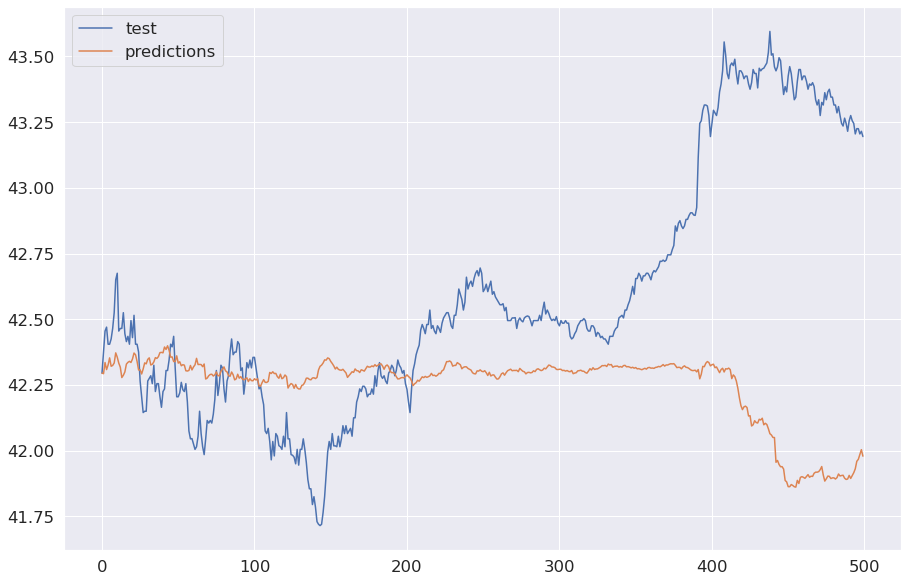

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(test[:500], label='test')
plt.plot(predictions[:500], label='predictions')
plt.legend()
plt.show()

Псомотрим на метркии

In [21]:
root_mean_squared_error(
    test[:500],
    predictions[:500]
)

0.6576020620888654

In [22]:
mean_absolute_percentage_error(
    test[:500],
    predictions[:500]
)

1.043657037633004

Как видим, преобразование Бокса-Кокса и дифференцирование позволило нам сделать адекватное предсказание.